In [1]:
# load the libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from itertools import product

               Close
Date                
2021-01-01  0.005685
2021-01-02  0.010615
2021-01-03  0.009771
2021-01-04  0.009767
2021-01-05  0.009920
...              ...
2022-07-16  0.064280
2022-07-17  0.063107
2022-07-18  0.067715
2022-07-19  0.069013
2022-07-20  0.070945

[566 rows x 1 columns]


<AxesSubplot:xlabel='Date'>

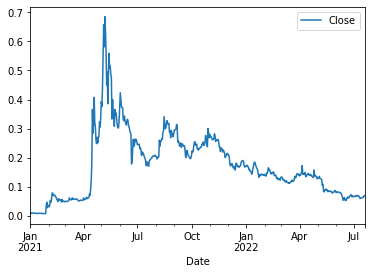

In [2]:
# load the data
df = pd.read_csv('DOGE-USD-daily 2021.csv', header = 0)
df.dropna()
df.head()
close_price = df[["Date", "Close"]].copy()
close_price.index = pd.to_datetime(close_price['Date'])
close_price.drop(columns='Date',inplace=True)
print(close_price)
close_price.plot()

<AxesSubplot:xlabel='Date', ylabel='Resid'>

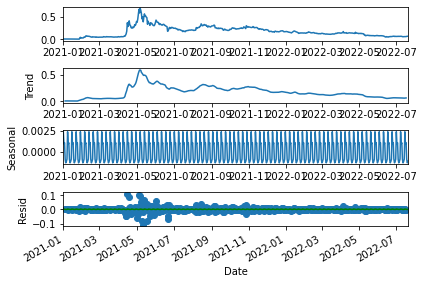

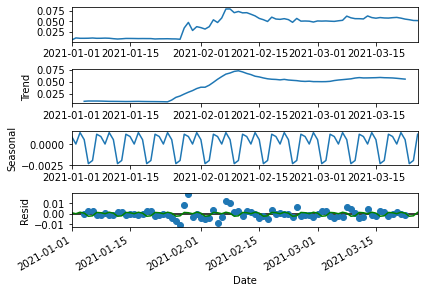

In [3]:
# decompose data
decompose_data = seasonal_decompose(close_price, model="additive")
decompose_data.plot()
seasonality=decompose_data.seasonal
seasonality.plot(color='green')

first_n_row = close_price.iloc[0:84, :1]

decompose_data2 = seasonal_decompose(first_n_row, model="additive")
decompose_data2.plot()
seasonality2=decompose_data2.seasonal
seasonality2.plot(color='green')

The series is stationary


/Users/phyllis/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


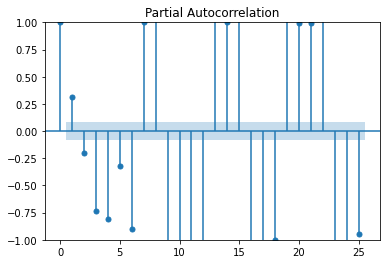

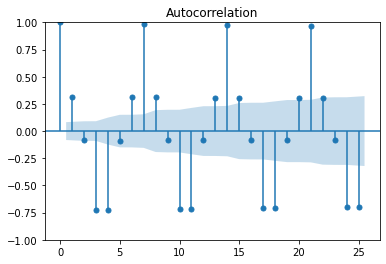

In [4]:
# check stationary
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')
check_stationarity(seasonality)
# plot acf, pacf
plot_pacf(seasonality, lags =25)
plt.show()
plot_acf(seasonality, lags =25)
plt.show()

In [5]:
# make the data stationary
ln_close = np.log(close_price)
x0 = ln_close.loc["2022-06-20"]

dftest = adfuller(ln_close.dropna(), autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -2.9401136920222375
2. P-Value :  0.04087823222146376
3. Num Of Lags :  3
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 562
5. Critical Values :
	 1% :  -3.442039359113542
	 5% :  -2.8666965134862514
	 10% :  -2.5695162601790758


In [6]:
# split data
m = 30
print(len(ln_close))
train_data = ln_close[0:len(ln_close)-m]
test_data = ln_close[len(ln_close)-m:len(ln_close)]

566


In [11]:
# read exgo varibale data
UDI = pd.read_excel('US Dollar Index.xlsx', index_col=0, header=0)
udi = UDI["UDI"]

BTC = pd.read_excel("BTC-USD.xlsx", index_col=0, header=0)
BTC_Close = BTC["BTC_Close"]

MSCI_AIWC = pd.read_excel('MSCI_AIWC.xlsx', index_col=0, header=0)
MSCI_AIWC = MSCI_AIWC["close"]

COVID_19= pd.read_excel('WHO_ USA_ COVID-19.xlsx', index_col=0, header=0)
YTD = COVID_19["YTD"]
NCC = COVID_19["New_Confirmed_Cases"]

Oil = pd.read_excel('Futures Settlement Price (Continuous)_ Brent Crude Oil.xlsx', index_col=0, header=0)
Brent = Oil["Brent"]

# merge exgo variable data
merge_df = train_data.join(udi)
merge_df["UDI"].fillna(method='ffill', inplace=True)
merge_df = merge_df.join(BTC_Close)
merge_df["BTC_Close"].fillna(method='ffill', inplace=True)
merge_df = merge_df.join(MSCI_ACWI)
merge_df["close"].fillna(method='ffill', inplace=True)
merge_df = merge_df.join(YTD)
merge_df["YTD"].fillna(method='ffill', inplace=True)
merge_df = merge_df.join(NCC)
merge_df["New_Confirmed_Cases"].fillna(method='ffill', inplace=True)
merge_df = merge_df.join(Brent)
merge_df["Brent"].fillna(method='ffill', inplace=True)
merge_df.rename(columns = {'close':'MSCI_ACWI'}, inplace = True)
exog_lst = merge_df.iloc[: , 1:]
exog_lst
# find relevant exog variables
model = sm.tsa.statespace.SARIMAX(
    train_data,
    exog=exog_lst,
    order=(1, 0, 1),
    seasonal_order=(1, 1, 1, 7),
    enforce_stationarity=False, enforce_invertibility=False,
    freq="D").fit(method="powell", disp=False)

model.summary()
# only select BTC_Close

/Users/phyllis/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Close   No. Observations:                  536
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 7)   Log Likelihood                 444.033
Date:                           Sun, 15 Jan 2023   AIC                           -866.067
Time:                                   20:32:13   BIC                           -819.274
Sample:                               01-01-2021   HQIC                          -847.736
                                    - 06-20-2022                                         
Covariance Type:                             opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
UDI                    -0.0095      0.022     -0.437      0.662      -0.052       0.033
BTC_Close            2.374e-05   2.05e-06     11.572      0.000    1.97e-05    2.78e-05
MSCI_ACWI               0.0011      0.001      0.745      0.456      -0.002       0.004
YTD                 -5.398e-09   4.33e-08     -0.125      0.901   -9.03e-08    7.95e-08
New_Confirmed_Cases  1.264e-08   2.04e-07      0.062      0.950   -3.86e-07    4.12e-07
Brent                   0.0002      0.004      0.053      0.957      -0.007       0.008
ar.L1                   0.9802      0.005    197.120      0.000       0.970       0.990
ma.L1                   0.0143      0.025      0.563      0.574      -0.036       0.064
ar.S.L7                 0.0084      0.033      0.255      0.799      -0.056       0.073
ma.S.L7                -1.0502      0.038    -27.562      0.000      -1.125      -0.975
sigma2                  0.0093      0.000     22.198      0.000       0.008       0.010
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             40645.96
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.05   Skew:                             3.54
Prob(H) (two-sided):                  0.00   Kurtosis:                        45.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
p = q = range(0,4)
Ps = Qs = range(0,4)
parameters = product(p, q, Ps, Qs)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [13]:
# calculate MAPE
def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100
# Tune the model
# grid search to select parameter
def gs_arima(ts, parameters_list, d, Ds, s, opt_method='powell', exog = exog_lst, freq='D'):
    results = []
    best_aic = float("inf")
    for param in parameters_list:
        # we need try-except because on some combinations model might fail to converge
        try:
            model = sm.tsa.statespace.SARIMAX(
                ts,
                order=(param[0], d, param[1]),
                seasonal_order=(param[2], Ds, param[3], s),
                enforce_stationarity=False, enforce_invertibility=False,
                exog = exog,
                freq=freq).fit(method=opt_method, disp=False)
        except:
            continue

       # choose model with the smallest AIC
        aic = model.aic
        if aic < best_aic:
            better_model = model
            best_aic = aic
            better_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table, better_param, better_model

# merge exgo variable for test_data
merge_df2 = test_data.join(udi)
merge_df2["UDI"].fillna(method='ffill', inplace=True)
merge_df2 = merge_df2.join(BTC_Close)
merge_df2["BTC_Close"].fillna(method='ffill', inplace=True)
merge_df2 = merge_df2.join(MSCI_AIWC)
merge_df2["close"].fillna(method='ffill', inplace=True)
merge_df2 = merge_df2.join(YTD)
merge_df2["YTD"].fillna(method='ffill', inplace=True)
merge_df2 = merge_df2.join(NCC)
merge_df2["New_Confirmed_Cases"].fillna(method='ffill', inplace=True)
merge_df2.rename(columns = {'close':'MSCI_AIWC'}, inplace = True)
merge_df2 = merge_df2.join(Brent)
merge_df2["Brent"].fillna(method='ffill', inplace=True)
exog_test = merge_df2.iloc[: , 1:]

In [14]:
# tune the model to find the best one
# D = 1
result_table, best_param, best_model =gs_arima(train_data, parameters_list, 0, 1, 7, opt_method='powell',
                                               exog=exog_lst.BTC_Close, freq='D')
print(result_table)
print(best_param)
print(best_model)

/Users/phyllis/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/phyllis/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/phyllis/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/phyllis/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/phyllis/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency i

       parameters          aic
0    (1, 3, 2, 3) -1125.078562
1    (2, 3, 2, 3) -1118.801726
2    (3, 3, 2, 3) -1115.948447
3    (1, 2, 2, 3) -1113.095631
4    (3, 2, 2, 3) -1111.696329
..            ...          ...
251  (0, 0, 1, 1)   141.545139
252  (0, 0, 2, 0)   145.055583
253  (0, 0, 0, 2)   145.961990
254  (0, 0, 2, 1)   147.020997
255  (0, 0, 1, 2)   147.975054

[256 rows x 2 columns]
(1, 3, 2, 3)


In [15]:
# the best model is (1, 0, 3)*(2, 1, 3, 7)
final_model = sm.tsa.statespace.SARIMAX(
    train_data,
    exog=exog_lst.BTC_Close,
    order=(1, 0, 3),
    seasonal_order=(2, 1, 3, 7),
    enforce_stationarity=False, enforce_invertibility=False,
    freq="D").fit(method="powell", disp=False)

final_model.summary()

/Users/phyllis/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Close   No. Observations:                  536
Model:             SARIMAX(1, 0, 3)x(2, 1, 3, 7)   Log Likelihood                 573.539
Date:                           Sun, 15 Jan 2023   AIC                          -1125.079
Time:                                   20:47:22   BIC                          -1078.630
Sample:                               01-01-2021   HQIC                         -1106.859
                                    - 06-20-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
BTC_Close   2.352e-05    1.8e-06     13.080      0.000       2e-05     2.7e-05
ar.L1          0.9856      0.005    211.064      0.000       0.976       0.995
ma.L1          0.0075      0.030      0.252      0.801      -0.051       0.066
ma.L2          0.0703      0.029      2.395      0.017       0.013       0.128
ma.L3          0.1568      0.030      5.217      0.000       0.098       0.216
ar.S.L7       -1.0993      0.027    -41.448      0.000      -1.151      -1.047
ar.S.L14      -0.6487      0.024    -26.857      0.000      -0.696      -0.601
ma.S.L7        0.2484      0.051      4.867      0.000       0.148       0.348
ma.S.L14      -0.3749      0.053     -7.128      0.000      -0.478      -0.272
ma.S.L21      -0.7117      0.048    -14.829      0.000      -0.806      -0.618
sigma2         0.0059      0.000     27.537      0.000       0.005       0.006
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              4925.62
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.12   Skew:                             1.48
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.003016622097375293
5.40045291173503
94.59954708826497
1.3310906679611215e-05


<AxesSubplot:xlabel='Date'>

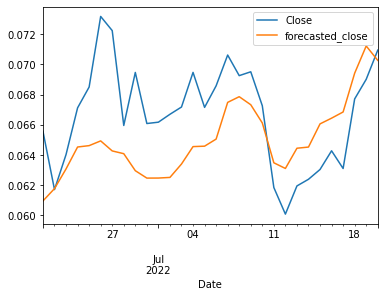

In [16]:
# predict
forecast_ln = final_model.predict(start=536, end=565, exog=exog_test.BTC_Close, dynamic=True)
mse_pre = mean_squared_error(test_data, forecast_ln)
# reverse the prediction
forecasted_close = np.exp(forecast_ln)
# plot the result
test_data2 = close_price[len(ln_close)-m:len(ln_close)]
test_data_df = pd.DataFrame(test_data2)
forecasted_close = pd.DataFrame(forecasted_close)
test_data_df.insert(1, column="forecasted_close", value=forecasted_close)
mape_sarimax = mape(test_data_df.Close, forecasted_close)
mse = mean_squared_error(test_data_df.Close, forecasted_close)
print(mse_pre)
print(mape_sarimax)
print(100-mape_sarimax)
print(mse)
test_data_df[["Close", "forecasted_close"]].plot()